# Tuần 4 — Feature Engineering

Mục tiêu: Chuyển thông tin thô thành các đặc trưng hữu ích cho mô hình. Notebook này thực hiện các bước từ đọc `clean_movies_with_labels.csv` đến xuất `clean_movies_features.csv` và vài biểu đồ kiểm tra nhanh.

In [1]:
# Import các thư viện cần thiết
# Mục đích: Chuẩn bị môi trường làm việc với pandas, numpy, seaborn, matplotlib
# Tác dụng: Cho phép xử lý dữ liệu, vẽ biểu đồ và tính toán số học
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# BƯỚC 1: Đọc dữ liệu đã gắn nhãn từ bước 3
# Mục đích: Tải dữ liệu từ file clean_movies_with_labels.csv để bắt đầu feature engineering
# Tác dụng: Cung cấp DataFrame gốc với nhãn success đã có, kiểm tra cấu trúc dữ liệu
input_path = '../../data/clean_movies_with_labels.csv'
df = pd.read_csv(input_path)
df = df.copy()
print(f'Loaded: {len(df)} rows, {len(df.columns)} columns')
print('Data types:')
print(df.dtypes.value_counts())
print('Missing per column:')
print(df.isna().sum()[df.isna().sum() > 0])

Loaded: 1020 rows, 22 columns
Data types:
object     11
float64     7
int64       4
Name: count, dtype: int64
Missing per column:
Release Date       1
release_year       1
release_month      1
release_weekday    1
dtype: int64


In [3]:
# BƯỚC 2: Trích xuất đặc trưng thời gian từ 'Release Date'
# Mục đích: Tạo các đặc trưng liên quan đến thời gian phát hành phim
# Tác dụng: Giúp mô hình học được pattern theo năm, tháng, quý, ngày trong tuần, mùa lễ
if 'Release Date' in df.columns:
    df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
    df['release_year'] = df['Release Date'].dt.year
    df['release_month'] = df['Release Date'].dt.month
    df['release_weekday'] = df['Release Date'].dt.dayofweek
    df['release_quarter'] = df['Release Date'].dt.quarter
    # Holiday season: Nov, Dec, Jan (heuristic đơn giản)
    df['is_holiday_season'] = df['release_month'].isin([11,12,1]).astype(int)
    print('Added time features: release_year, release_month, release_weekday, release_quarter, is_holiday_season')
else:
    print('No Release Date column found')

Added time features: release_year, release_month, release_weekday, release_quarter, is_holiday_season


In [22]:
# BƯỚC 3: Nhóm runtime và tạo runtime_hours
# Mục đích: Phân loại thời lượng phim thành các nhóm và tạo đặc trưng số
# Tác dụng: Giúp mô hình phân biệt phim ngắn, trung bình, dài; dễ xử lý hơn categorical
runtime_candidates = [c for c in df.columns if c.lower() in ['runtime','runtime_minutes','length']]
if runtime_candidates:
    col = runtime_candidates[0]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df['runtime_minutes'] = df[col]
    df['runtime_hours'] = df['runtime_minutes'] / 60.0
    def runtime_group(minutes):
        if pd.isna(minutes):
            return 'Unknown'
        elif minutes < 60:
            return '< 1 hour'
        elif 60 <= minutes < 90:
            return '1-1.5 hours'
        elif 90 <= minutes < 120:
            return '1.5-2 hours'
        elif 120 <= minutes < 150:
            return '2-2.5 hours'
        else:
            return '> 2.5 hours'
    df['runtime_group'] = df['runtime_minutes'].apply(runtime_group)
    print(f'Runtime column used: {col} - sample counts:')
    print(df['runtime_group'].value_counts(dropna=False))
else:
    print('No runtime column found; skipping runtime grouping')

Runtime column used: Runtime - sample counts:
runtime_group
1.5-2 hours    642
2-2.5 hours    255
1-1.5 hours     68
> 2.5 hours     49
< 1 hour         6
Name: count, dtype: int64


In [14]:
# BƯỚC 4: Đếm số diễn viên chính từ cột Stars
# Mục đích: Tạo đặc trưng số lượng diễn viên chính từ cột cast
# Tác dụng: Phim có nhiều diễn viên nổi tiếng có thể ảnh hưởng đến thành công
import ast
import re

def count_cast_fixed(value):
    # Trả về số diễn viên chính (int). Trường hợp không rõ/NaN -> 0
    if pd.isna(value):
        return 0
    if isinstance(value, list):
        return len([v for v in value if str(v).strip()])
    s = str(value).strip()
    if not s or s.lower() in ('nan','none','[]'):
        return 0
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return len([v for v in parsed if str(v).strip()])
    except (ValueError, SyntaxError):
        pass
    parts = [p.strip() for p in re.split('[,;|\\n]', s) if p.strip()]
    return len(parts)

if 'Stars' in df.columns:
    df['num_main_cast'] = df['Stars'].apply(count_cast_fixed)
    print('Added feature: num_main_cast')
else:
    print('No Stars column found; skipping main cast count')

Added feature: num_main_cast


In [15]:
# BƯỚC 5: Chuẩn hóa Genres - tách, đếm, one-hot cho top N
# Mục đích: Xử lý cột Genres thành các đặc trưng có thể dùng cho ML
# Tác dụng: Tạo one-hot encoding cho genres phổ biến, đếm số genres, xác định genre chính
if 'Genres' in df.columns:
    def extract_genres(x):
        if pd.isna(x):
            return []
        s = str(x)
        s = s.replace('[','').replace(']','').replace('"','').replace("'","")
        parts = [p.strip() for p in re.split('[,;|\\n]', s) if p.strip()]
        return parts
    import re
    df['genres_list'] = df['Genres'].apply(extract_genres)
    df['num_genres'] = df['genres_list'].apply(len)
    genres_series = df.explode('genres_list')['genres_list'].dropna()
    top_genres = genres_series.value_counts().head(15).index.tolist()
    print('Top genres:', top_genres)
    for g in top_genres:
        df[f'genre_{g}'] = df['genres_list'].apply(lambda lst: int(g in lst) if isinstance(lst, list) else 0)
    def most_common_genre(lst):
        if not isinstance(lst, list) or len(lst)==0:
            return np.nan
        for g in top_genres:
            if g in lst:
                return g
        return lst[0]
    df['main_genre'] = df['genres_list'].apply(most_common_genre)
else:
    print('No Genres column found; skipping genres processing')

Top genres: ['Action', 'Adventure', 'Comedy', 'Drama', 'Thriller', 'Science Fiction', 'Family', 'Fantasy', 'Crime', 'Animation', 'Horror', 'Romance', 'Mystery', 'History', 'Music']


In [16]:
# BƯỚC 6: Chuẩn hóa Country - tách, đếm, one-hot cho top N
# Mục đích: Xử lý cột Production Countries thành đặc trưng quốc gia
# Tác dụng: Tạo one-hot encoding cho quốc gia phổ biến, flag USA, nhóm 'Other'
import re
# Tên cột thực tế từ CSV: 'Production Countries'
if 'Production Countries' in df.columns:
    ccol = 'Production Countries'
    def first_country(x):
        if pd.isna(x):
            return np.nan
        s = str(x).replace('[','').replace(']','').replace('"','').replace("'","")
        parts = [p.strip() for p in re.split('[,;|\\n]', s) if p.strip()]
        return parts[0] if parts else np.nan
    df['country_simple'] = df[ccol].apply(first_country)
    top_countries = df['country_simple'].value_counts().head(10).index.tolist()
    df['country_simple'] = df['country_simple'].fillna('Unknown')
    df['country_grouped'] = df['country_simple'].apply(lambda x: x if x in top_countries else 'Other')
    for ctry in top_countries:
        df[f'is_{ctry.replace(" ","_").lower()}'] = (df['country_grouped'] == ctry).astype(int)
    df['is_usa'] = (df['country_grouped'].str.lower().str.contains('united states')).astype(int)
    print('Country normalization done. Top countries:', top_countries)
else:
    print('No Production Countries column found; skipping country normalization')

Country normalization done. Top countries: ['United States of America', 'United Kingdom', 'Canada', 'Vietnam', 'China', 'France', 'South Korea', 'Australia', 'Japan', 'India']


In [17]:
# BƯỚC 7: Xử lý các đặc trưng số (log-transform, ROI check)
# Mục đích: Chuẩn hóa các đặc trưng số để tránh outlier và phân bố lệch
# Tác dụng: Log-transform Budget/Revenue, clip ROI, đảm bảo kiểu dữ liệu đúng
if 'Budget' in df.columns:
    df['Budget'] = pd.to_numeric(df['Budget'], errors='coerce')
    df['Budget_log'] = np.log10(df['Budget'].clip(lower=1))
if 'Revenue' in df.columns:
    df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
    df['Revenue_log'] = np.log10(df['Revenue'].clip(lower=1))
if 'roi' not in df.columns and 'Revenue' in df.columns and 'Budget' in df.columns:
    df['roi'] = df['Revenue'] / df['Budget']
if 'roi' in df.columns:
    df['roi_clipped'] = df['roi'].clip(upper=df['roi'].quantile(0.99))
if 'Vote Average' in df.columns:
    df['Vote Average'] = pd.to_numeric(df['Vote Average'], errors='coerce')
print('Numeric transforms done: Budget_log, Revenue_log, roi_clipped (if available)')

Numeric transforms done: Budget_log, Revenue_log, roi_clipped (if available)


In [18]:
# BƯỚC 8: Tạo đặc trưng kết hợp (nếu hợp lý)
# Mục đích: Tạo các đặc trưng tương tác để capture mối quan hệ phức tạp
# Tác dụng: Budget theo năm, ROI kết hợp vote, tương tác cast-genre
if 'release_year' in df.columns and 'Budget' in df.columns:
    df['budget_per_year'] = df['Budget'] / (datetime.now().year - df['release_year'] + 1).clip(lower=1)
if 'roi' in df.columns and 'Vote Average' in df.columns:
    df['roi_vs_vote'] = df['roi'] * (df['Vote Average'] / 10.0)
if 'num_main_cast' in df.columns and 'num_genres' in df.columns:
    df['cast_genre_interaction'] = df['num_main_cast'] * df['num_genres']
print('Created optional combined features: budget_per_year, roi_vs_vote, cast_genre_interaction (if available)')

Created optional combined features: budget_per_year, roi_vs_vote, cast_genre_interaction (if available)


In [19]:
# BƯỚC 9: Lập danh sách đặc trưng cuối cùng và kiểm tra nhanh
# Mục đích: Thu thập tất cả đặc trưng đã tạo để dùng cho mô hình
# Tác dụng: Liệt kê features, kiểm tra missing values, chuẩn bị cho bước tiếp theo
feature_candidates = [
    'release_year','release_month','release_weekday','release_quarter','is_holiday_season',
    'runtime_minutes','runtime_hours','runtime_group','num_main_cast','num_genres',
    'Budget','Budget_log','Revenue','Revenue_log','roi','roi_clipped','Vote Average',
    'main_genre','country_grouped','is_usa'
]
genre_cols = [c for c in df.columns if c.startswith('genre_')]
feature_candidates += genre_cols
country_cols = [c for c in df.columns if c.startswith('is_') and c != 'is_usa']
feature_candidates += country_cols
feature_list = [c for c in feature_candidates if c in df.columns]
print('Final feature list (sample):')
print(feature_list)
print('Missing values in chosen features:')
print(df[feature_list].isna().sum())

Final feature list (sample):
['release_year', 'release_month', 'release_weekday', 'release_quarter', 'is_holiday_season', 'runtime_minutes', 'runtime_hours', 'runtime_group', 'num_main_cast', 'num_genres', 'Budget', 'Budget_log', 'Revenue', 'Revenue_log', 'roi', 'roi_clipped', 'Vote Average', 'main_genre', 'country_grouped', 'is_usa', 'genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Drama', 'genre_Thriller', 'genre_Science Fiction', 'genre_Family', 'genre_Fantasy', 'genre_Crime', 'genre_Animation', 'genre_Horror', 'genre_Romance', 'genre_Mystery', 'genre_History', 'genre_Music', 'is_holiday_season', 'is_united_states_of_america', 'is_united_kingdom', 'is_canada', 'is_vietnam', 'is_china', 'is_france', 'is_south_korea', 'is_australia', 'is_japan', 'is_india']
Missing values in chosen features:
release_year                   1
release_month                  1
release_weekday                1
release_quarter                1
is_holiday_season              0
runtime_minutes       

In [20]:
# BƯỚC 10: Lưu dữ liệu features đã xử lý
# Mục đích: Xuất DataFrame với tất cả đặc trưng đã tạo
# Tác dụng: Tạo file clean_movies_features.csv để dùng cho tuần 5 (modeling)
out_path = '../../data/clean_movies_features.csv'
df.to_csv(out_path, index=False)
print(f'Saved features dataframe to: {out_path} (rows: {len(df)}, columns: {len(df.columns)})')

Saved features dataframe to: ../../data/clean_movies_features.csv (rows: 1020, columns: 65)


/tmp/ipykernel_24956/2033298231.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='runtime_group', palette='Set3')


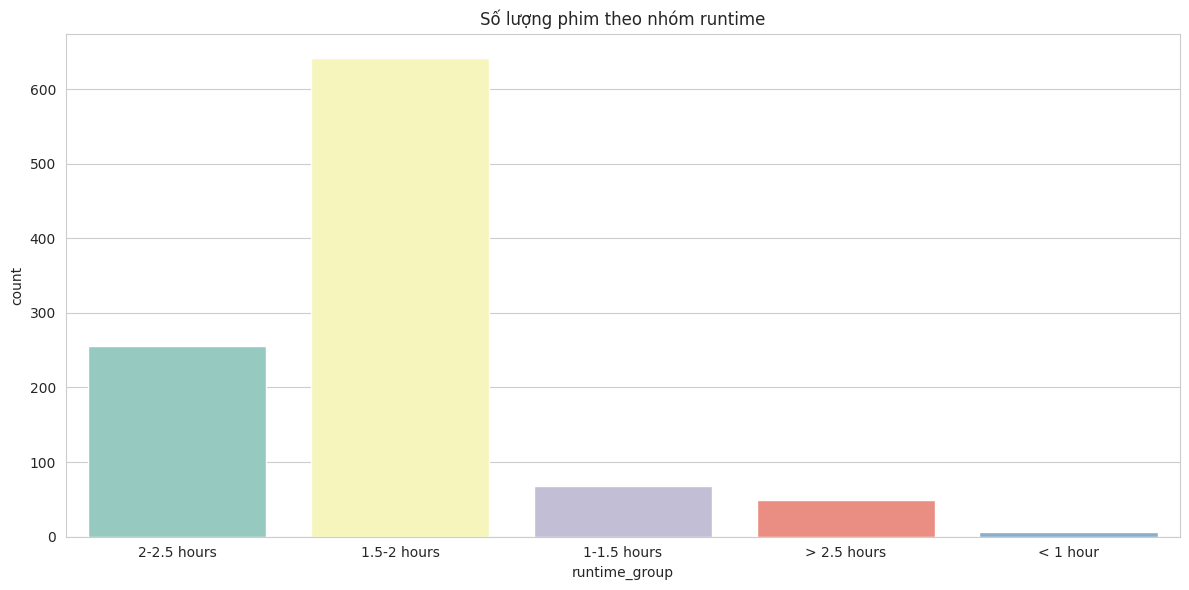

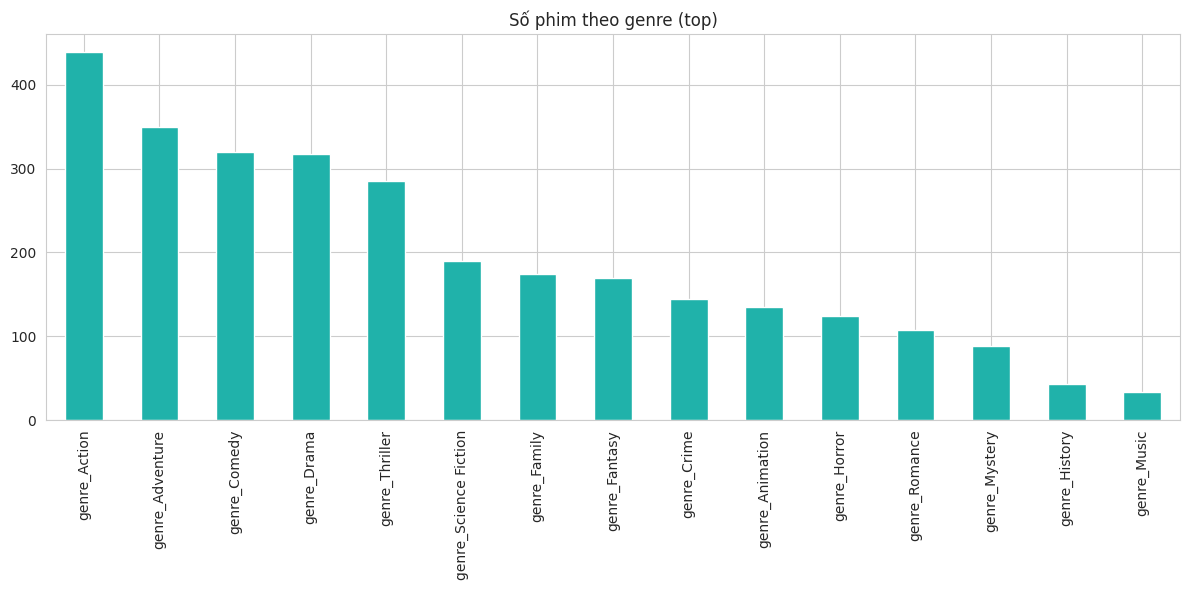

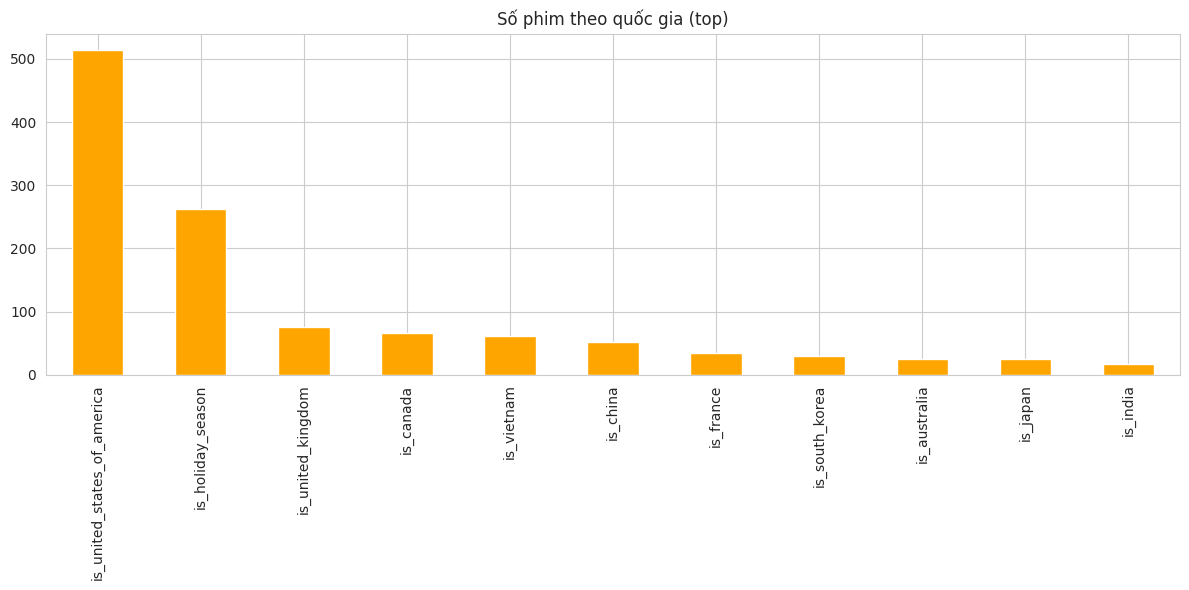

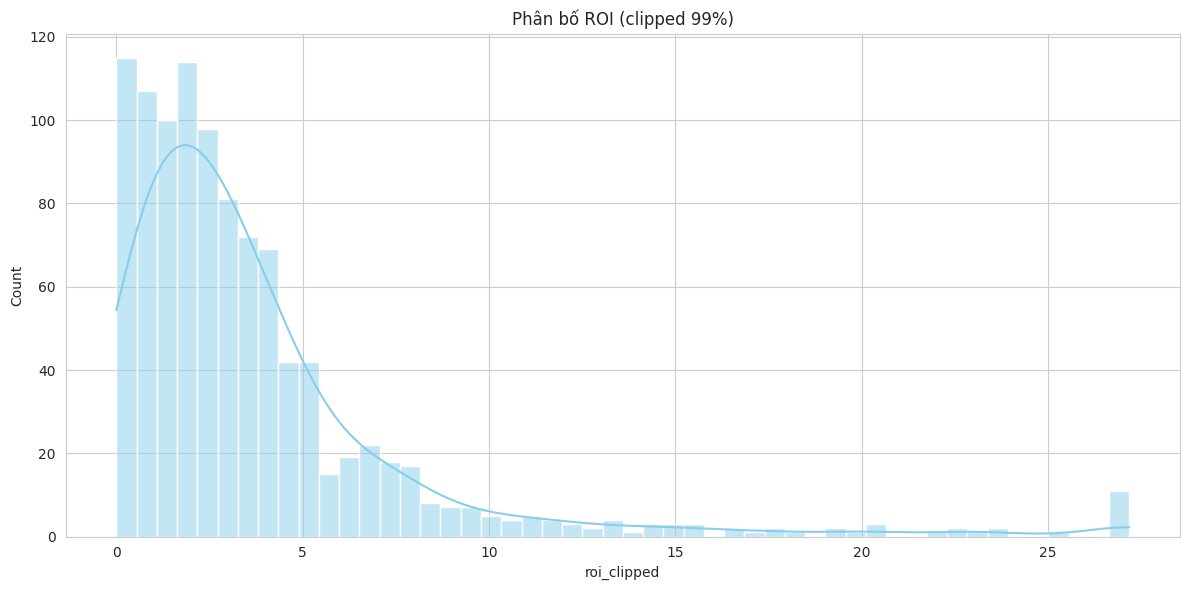

In [21]:
# BƯỚC 11: Một vài biểu đồ kiểm tra nhanh
# Mục đích: Visualize phân bố của các đặc trưng chính
# Tác dụng: Kiểm tra chất lượng dữ liệu, phát hiện outlier hoặc pattern bất thường
if 'runtime_group' in df.columns:
    sns.countplot(data=df, x='runtime_group', palette='Set3')
    plt.title('Số lượng phim theo nhóm runtime')
    plt.tight_layout()
    plt.show()
genre_cols = [c for c in df.columns if c.startswith('genre_')]
if genre_cols:
    counts = df[genre_cols].sum().sort_values(ascending=False)
    counts.plot(kind='bar', color='lightseagreen')
    plt.title('Số phim theo genre (top)')
    plt.tight_layout()
    plt.show()
country_cols = [c for c in df.columns if c.startswith('is_') and c != 'is_usa']
if country_cols:
    counts = df[country_cols].sum().sort_values(ascending=False)
    counts.plot(kind='bar', color='orange')
    plt.title('Số phim theo quốc gia (top)')
    plt.tight_layout()
    plt.show()
if 'roi_clipped' in df.columns:
    sns.histplot(df['roi_clipped'].dropna(), bins=50, kde=True, color='skyblue')
    plt.title('Phân bố ROI (clipped 99%)')
    plt.tight_layout()
    plt.show()